# Verification experiment - NARMAX

I generate data according to a NARMAX model and recover parameters using both a FEM estimator and an RLS estimator. 

The estimators are validated with a simulation error experiment.

In [1]:
using Revise
using ProgressMeter
using LinearAlgebra
using Plots
pyplot();

## Data generation

#### Experimental parameters

In [2]:
# Polynomial degrees (t = true, m = model)
deg_t = 3
deg_m = 3;

In [3]:
# True orders
M1_t = 3
M2_t = 3
M3_t = 3
M_t = M1_t + 1 + M2_t + M3_t

# Model orders
M1_m = 3
M2_m = 3
M3_m = 3
M_m = M1_m + 1 + M2_m + M3_m

# Number of coefficients
N_t = M_t*deg_t + 1
N_m = M_m*deg_m + 1;

In [4]:
# True basis function
PΨ = zeros(M_t,1); for d=1:deg_t; PΨ = hcat(d .*Matrix{Float64}(I,M_t,M_t), PΨ); end
ψ(x::Array{Float64,1}) = [prod(x.^PΨ[:,k]) for k = 1:size(PΨ,2)];

# Model basis function
PΦ = zeros(M_m,1); for d=1:deg_m; PΦ = hcat(d .*Matrix{Float64}(I,M_m,M_m), PΦ); end
ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)];

In [5]:
# Parameters
τ_true = 1e6
θ_true = .5 .*(rand(N_t,) .- 0.5);
θ_true[end] = 0.;

In [6]:
# Length of transient period
tt = 50

# Length of observed signal
ts = 800 + tt

# Length of simulation horizon
T = 1000 + ts;

#### Generate input

In [7]:
include("fMultiSinGen.jl")

# Parameters
num_periods = 10
points_period = 1000
num_real = 1
fMin = 0.0
fMax = 100.0
fs = 10 .* fMax
uStd = 0.1

# Input frequency and amplitude
input, inputfreq = fMultiSinGen(points_period, 
                                num_periods, 
                                num_real, 
                                fMin=fMin, 
                                fMax=fMax, 
                                fs=fs, 
                                type_signal="odd", 
                                uStd=uStd);

# Scale down
# input /= 10.;

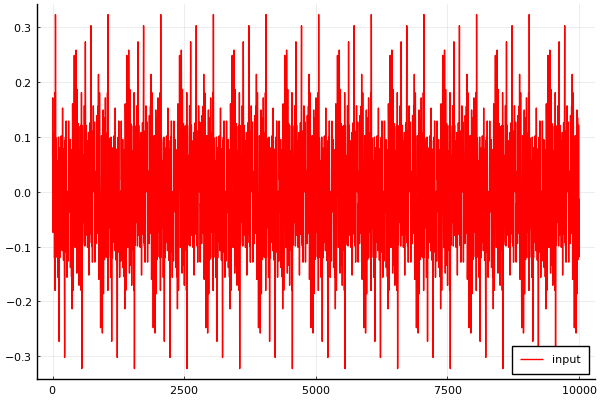

In [8]:
plot(input, color="red", label="input")

In [9]:
savefig("figures/NARMAX-generated-input_deg"*string(deg_t)*"_order"*string(M_t)*".png")

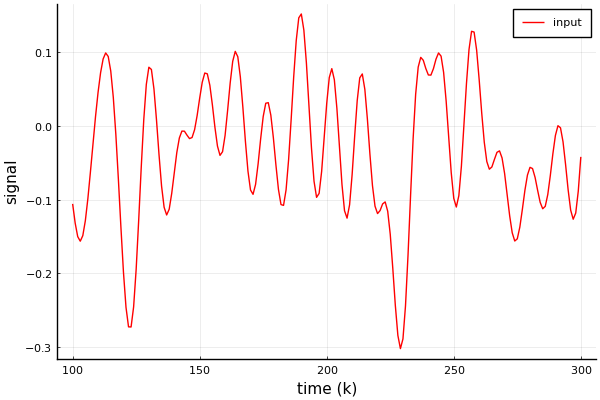

In [10]:
ix_zoom = 100:300
plot(ix_zoom, input[ix_zoom], color="red", label="input", xlabel="time (k)", ylabel="signal")

In [11]:
savefig("figures/NARMAX-generated-input_deg"*string(deg_t)*"_order"*string(M_t)*"_zoom100-300.png")

#### Generate output

In [12]:
# Observation array
output = zeros(T,)
errors = zeros(T,)

for k = 1:T

    # Generate noise
    errors[k] = sqrt(inv(τ_true))*randn(1)[1]

    # Output
    if k < (maximum([M1_t, M2_t, M3_t])+1)
        output[k] = input[k] + errors[k]
    else
        # Update history vectors
        x_kmin1 = output[k-1:-1:k-M1_t]
        z_kmin1 = input[k-1:-1:k-M2_t]
        r_kmin1 = errors[k-1:-1:k-M3_t]

        # Compute output
        output[k] = θ_true'*ψ([x_kmin1; input[k]; z_kmin1; r_kmin1]) + errors[k]
    end
end

# Y-Limits of output signal
ylims = [minimum(output[tt:T]), maximum(output[tt:T])];

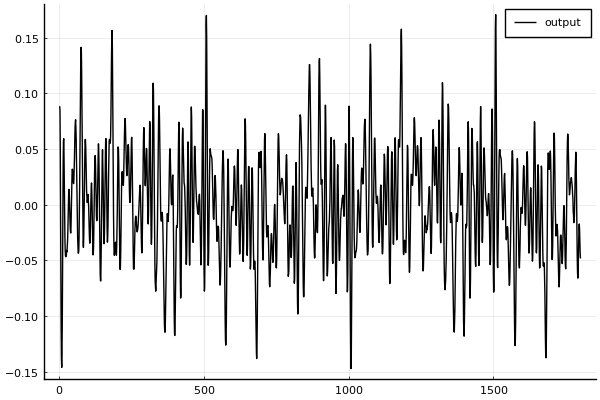

In [13]:
plot(output[tt:T], color="black", label="output")

In [14]:
savefig("figures/NARMAX-generated-output_deg"*string(deg_t)*"_order"*string(M_t)*".png")

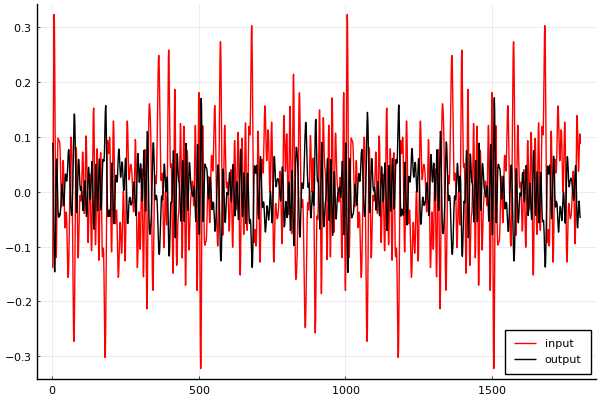

In [15]:
plot(input[tt:T], color="red", label="input")
plot!(output[tt:T], color="black", label="output")

In [16]:
savefig("figures/NARMAX-generated-input+output_deg"*string(deg_t)*"_order"*string(M_t)*".png")

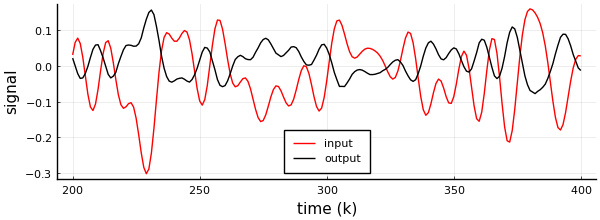

In [17]:
# Visualize signal
zoom_t = 200:400
if T > length(zoom_t)
    plot(zoom_t, input[zoom_t], color="red", label="input", xlabel="time (k)", ylabel="signal", size=(600,220))
    plot!(zoom_t, output[zoom_t], color="black", label="output", xlabel="time (k)", ylabel="signal")
else 
    plot(tt:T, input[tt:T], color="red", label="input", xlabel="time (k)", ylabel="signal")
    plot!(tt:T, output[tt:T], color="black", label="output", xlabel="time (k)", ylabel="signal")
end

In [18]:
savefig("figures/NARMAX-generated-input+output_deg"*string(deg_t)*"_order"*string(M_t)*"_zoom200-400.png")

## Model specification

In [19]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov
using NARMAX

In [20]:
graph = FactorGraph()

# Observed variables
@RV x_kmin1; placeholder(x_kmin1, :x_kmin1, dims=(M1_m,))
@RV z_kmin1; placeholder(z_kmin1, :z_kmin1, dims=(M2_m,))
@RV r_kmin1; placeholder(r_kmin1, :r_kmin1, dims=(M3_m,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(N_m,)), placeholder(:v_θ, dims=(N_m, N_m)))

# Likel7ihood
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, x_kmin1, u_k, z_kmin1, r_kmin1, τ, g=ϕ)
placeholder(y_k, :y_k)

ForneyLab.draw(graph)

# Compile message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q)
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 5831309373725127674 -->
 
 5831309373725127674 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 11052949595254576635 -->
 
 11052949595254576635 
 
 placeholder_m_θ 
 
<!-- 5831309373725127674--11052949595254576635 -->
 
 5831309373725127674--11052949595254576635 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 2027822275230295831 -->
 
 2027822275230295831 
 
 placeholder_v_θ 
 
<!-- 5831309373725127674--2027822275230295831 -->
 
 5831309373725127674--2027822275230295831 
 
 v_θ 
 1 out 
 3 v 
 
<!-- 594159752288855039 -->
 
 594159752288855039 
 
 placeholder_x_kmin1 
 
<!-- 8859566517648721672 -->
 
 8859566517648721672 
 
 placeholder_a_τ 
 
<!-- 4803422753169357658 -->
 
 4803422753169357658 
 
 placeholder_u_k 
 
<!-- 9239480279468844199 -->
 
 9239480279468844199 
 
 placeholder_r_kmin1 
 
<!-- 4597151352997409340 -->
 
 4597151352997409340 
 
 placeholder_z_kmin1 
 
<!-- 437986103491603781 -->
 
 437986103491603781 
 
 placeholder_y_k 
 
<!-- 1945495353490885199 -->
 
 1945495353490885199 
 
 NARMAX 
 nautoregressivemovingaveragex_1 
 
<!-- 437986103491603781--1945495353490885199 -->
 
 437986103491603781--1945495353490885199 
 
 y_k 
 1 y 
 1 out 
 
<!-- 18077213802938580180 -->
 
 18077213802938580180 
 
 Gam 
 gamma_1 
 
<!-- 18077213802938580180--8859566517648721672 -->
 
 18077213802938580180--8859566517648721672 
 
 a_τ 
 1 out 
 2 a 
 
<!-- 13365612923414048889 -->
 
 13365612923414048889 
 
 placeholder_b_τ 
 
<!-- 18077213802938580180--13365612923414048889 -->
 
 18077213802938580180--13365612923414048889 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 1945495353490885199--5831309373725127674 -->
 
 1945495353490885199--5831309373725127674 
 
 θ 
 1 out 
 2 θ 
 
<!-- 1945495353490885199--594159752288855039 -->
 
 1945495353490885199--594159752288855039 
 
 x_kmin1 
 1 out 
 3 x 
 
<!-- 1945495353490885199--4803422753169357658 -->
 
 1945495353490885199--4803422753169357658 
 
 u_k 
 1 out 
 4 u 
 
<!-- 1945495353490885199--9239480279468844199 -->
 
 1945495353490885199--9239480279468844199 
 
 r_kmin1 
 1 out 
 6 r 
 
<!-- 1945495353490885199--4597151352997409340 -->
 
 1945495353490885199--4597151352997409340 
 
 z_kmin1 
 1 out 
 5 z 
 
<!-- 1945495353490885199--18077213802938580180 -->
 
 1945495353490885199--18077213802938580180 
 
 τ 
 1 out 
 7 τ

## Inference

In [21]:
# Initialize priors
θ_k = (zeros(N_m,), 10. .*Matrix{Float64}(I,N_m,N_m))
τ_k = (1e6, 1e0)

# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=θ_k[1], v=θ_k[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

# Preallocate parameter arrays
params_θ = (zeros(ts-tt+1,N_m), zeros(ts-tt+1,N_m,N_m))
params_τ = (zeros(ts-tt+1,1), zeros(ts-tt+1,1))

# Keep track of residuals
predictions_FEM = (zeros(T,), zeros(T,))
residuals = zeros(T,)

@showprogress for (ii,k) in enumerate(tt:ts)
    
    # Update history vectors
    x_kmin1 = output[k-1:-1:k-M1_m]
    z_kmin1 = input[k-1:-1:k-M2_m]
    r_kmin1 = residuals[k-1:-1:k-M3_m]
    
    # Predictions
    ϕx = ϕ([x_kmin1; input[k]; z_kmin1; r_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*θ_k[2]'*ϕx + inv(τ_k[1]/τ_k[2])
    
    # Compute prediction error
    residuals[k] = output[k] - predictions_FEM[1][k]
    
    # Set data 
    data = Dict(:y_k => output[k],
                :u_k => input[k],
                :x_kmin1 => x_kmin1,
                :z_kmin1 => z_kmin1,
                :r_kmin1 => r_kmin1,
                :m_θ => θ_k[1],
                :v_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])
    
    # Iterate updates
    for n = 1:10
        stepθ!(data, marginals)
        stepτ!(data, marginals)
    end    
    
    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafeCov(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
    
    # Store params
    params_θ[1][ii,:] = θ_k[1]
    params_θ[2][ii,:,:] = θ_k[2]
    params_τ[1][ii] = τ_k[1]
    params_τ[2][ii] = τ_k[2]
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


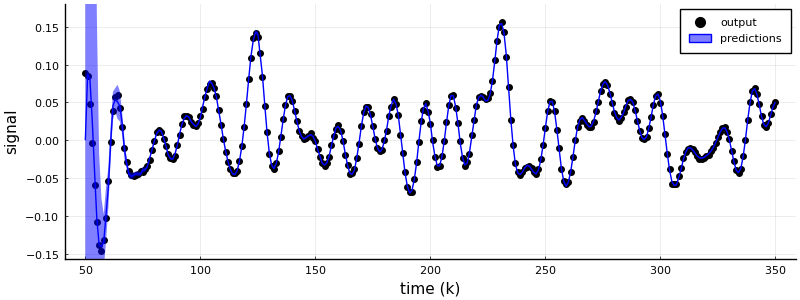

In [22]:
if (ts-tt) > 300
    scatter(tt:tt+300, output[tt:tt+300], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:tt+300, predictions_FEM[1][tt:tt+300], ribbon=[sqrt.(predictions_FEM[2][tt:tt+300]), sqrt.(predictions_FEM[2][tt:tt+300])], color="blue", label="predictions")
else
    scatter(tt:ts, output[tt:ts], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:ts, predictions_FEM[1][tt:ts], ribbon=[sqrt.(predictions_FEM[2][tt:ts]), sqrt.(predictions_FEM[2][tt:ts])], color="blue", label="predictions")
end

## Simulation

In [23]:
# Prepare array
simulations_FEM = (zeros(T,), zeros(T,))
simulations_FEM[1][1:ts] = output[1:ts]

@showprogress for k in ts:T
    
    # Update history vectors
    x_kmin1 = simulations_FEM[1][k-1:-1:k-M1_m]
    z_kmin1 = input[k-1:-1:k-M2_m]
    r_kmin1 = zeros(M3_m,)
    
    # Apply basis function
    ϕx = ϕ([x_kmin1; input[k]; z_kmin1; r_kmin1])
    
    # Predictions
    simulations_FEM[1][k] = θ_k[1]'*ϕx
    simulations_FEM[2][k] = ϕx'*θ_k[2]'*ϕx + inv(τ_k[1]/τ_k[2])
    
end

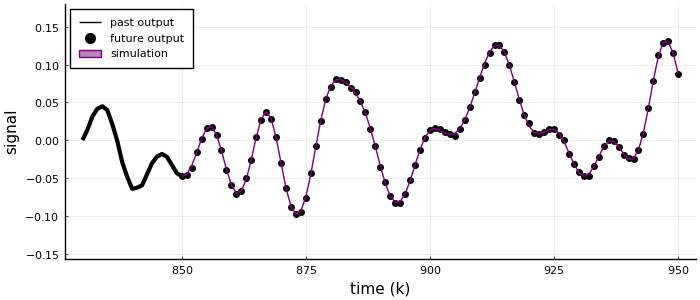

In [24]:
past = 20
ylims=[minimum(output[tt:T]), maximum(output[tt:T])]
plot(ts-past:ts, output[ts-past:ts], color="black", linewidth=3, label="past output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(700,300))

if T-ts > 100
    scatter!(ts:ts+100, output[ts:ts+100], color="black", label="future output", xlabel="time (k)", ylabel="signal")
    plot!(ts:ts+100, simulations_FEM[1][ts:ts+100], ribbon=[sqrt.(simulations_FEM[2][ts:ts+100]), sqrt.(simulations_FEM[2][ts:ts+100])], color="purple", label="simulation")
else
    scatter!(ts:T, output[ts:T], color="black", label="future output", xlabel="time (k)", ylabel="signal")
    plot!(ts:T, simulations_FEM[1][ts:T], ribbon=[sqrt.(simulations_FEM[2][ts:T]), sqrt.(simulations_FEM[2][ts:T])], color="purple", label="simulation")
end

In [25]:
savefig("figures/NARMAX-simulation_deg"*string(deg_m)*"_order"*string(M_m)*"_FEM.png")

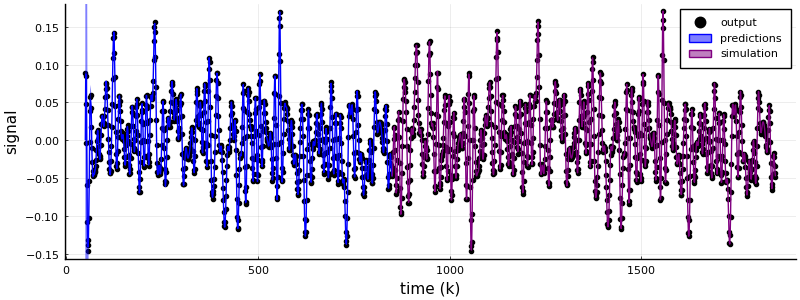

In [26]:
# Full signal
ylims=[minimum(output[tt:T]), maximum(output[tt:T])]
scatter(tt:T, output[tt:T], color="black", markersize=3, label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
plot!(tt:ts, predictions_FEM[1][tt:ts], ribbon=[sqrt.(predictions_FEM[2][tt:ts]), sqrt.(predictions_FEM[2][tt:ts])], color="blue", label="predictions")
plot!(ts:T, simulations_FEM[1][ts:T], ribbon=[sqrt.(simulations_FEM[2][ts:T]), sqrt.(simulations_FEM[2][ts:T])], color="purple", label="simulation")

In [27]:
savefig("figures/NARMAX-fullsignal_deg"*string(deg_m)*"_order"*string(M_m)*"_FEM.png")

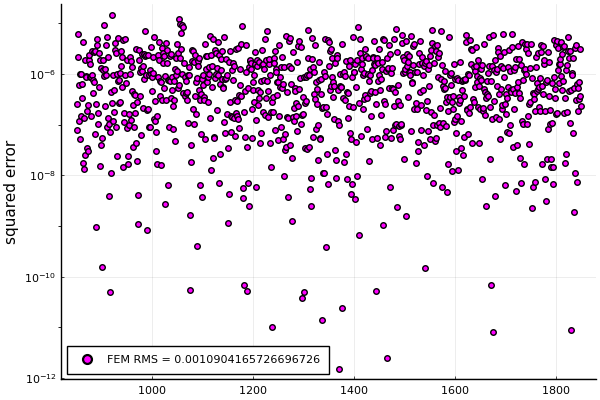

In [28]:
sqerror_FEM = (simulations_FEM[1][ts:T] - output[ts:T]).^2
RMS_FEM = sqrt(mean(sqerror_FEM))

scatter(ts:T, sqerror_FEM, label="FEM RMS = "*string(RMS_FEM), color="magenta", ylabel="squared error", yscale=:log10)

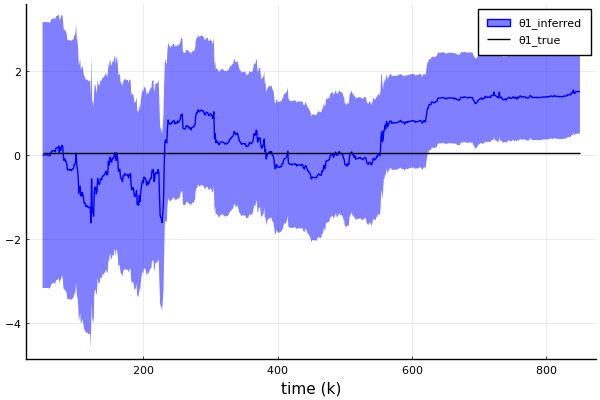

In [29]:
plot(tt:ts, params_θ[1][:,1], ribbon=[sqrt.(params_θ[2][:,1,1]) sqrt.(params_θ[2][:,1,1])], color="blue", xlabel="time (k)", label="θ1_inferred")
plot!(tt:ts, θ_true[1]*ones(ts-tt+1,), color="black", label="θ1_true")

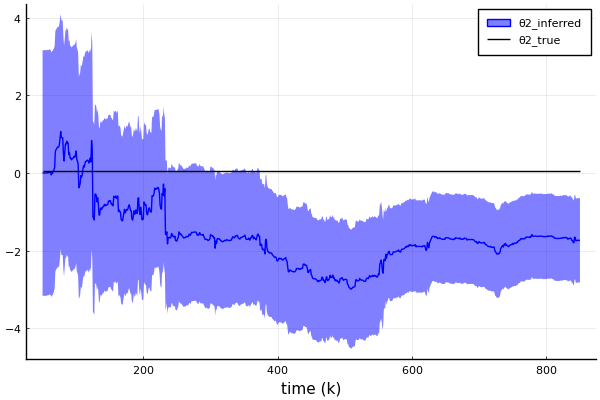

In [30]:
plot(tt:ts, params_θ[1][:,2], ribbon=[sqrt.(params_θ[2][:,2,2]) sqrt.(params_θ[2][:,2,2])], color="blue", xlabel="time (k)", label="θ2_inferred")
plot!(tt:ts, θ_true[2]*ones(ts-tt+1,), color="black", label="θ2_true")

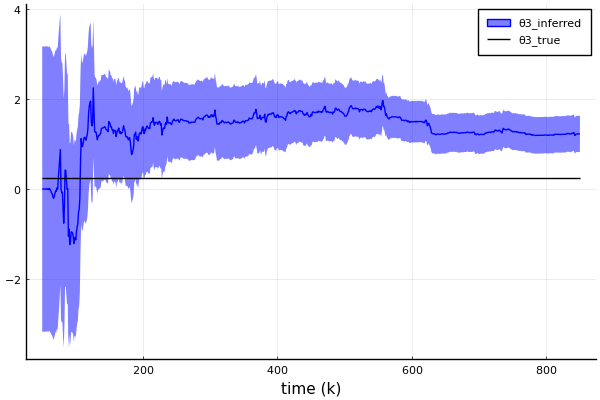

In [31]:
plot(tt:ts, params_θ[1][:,3], ribbon=[sqrt.(params_θ[2][:,3,3]) sqrt.(params_θ[2][:,3,3])], color="blue", xlabel="time (k)", label="θ3_inferred")
plot!(tt:ts, θ_true[3]*ones(ts-tt+1,), color="black", label="θ3_true")

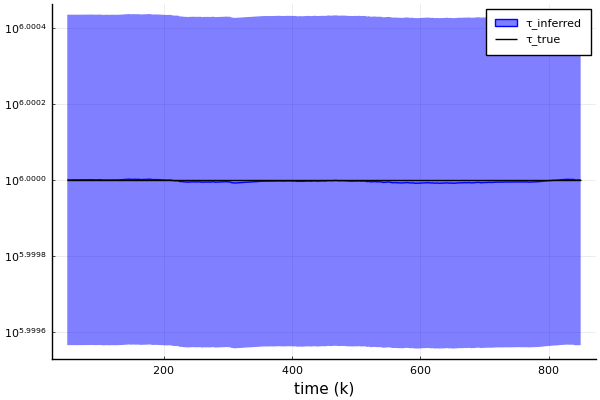

In [32]:
mτ = params_τ[1] ./ params_τ[2]
sτ = sqrt.(params_τ[1] ./ params_τ[2].^2)

plot(tt:ts, mτ, ribbon=[sτ sτ], color="blue", xlabel="time (k)", label="τ_inferred", yscale=:log10)
plot!(tt:ts, τ_true*ones(ts-tt+1,), color="black", label="τ_true")

## Baseline: RLS

Recursive least-squares estimator ([wiki](https://en.wikipedia.org/wiki/Recursive_least_squares_filter#Recursive_algorithm)).

In [33]:
# Parameters
λ = 1.00
P = λ.*Matrix{Float64}(I,N_m,N_m)
w_k = zeros(N_m,)
w = zeros(T,N_m)

# Preallocate prediction array
predictions_RLS = zeros(T,)
residuals = zeros(T,)

for k in tt:ts

    # Update data vector
    ϕx = ϕ([output[k-1:-1:k-M1_m]; input[k:-1:k-M2_m]; residuals[k-1:-1:k-M3_m]])

    # Update weights
    α = output[k] - w_k'*ϕx 
    g = P*ϕx*inv(λ + ϕx'*P*ϕx)
    P = inv(λ)*P - g*ϕx'*inv(λ)*P
    w_k = w_k + α*g

    # Prediction
    predictions_RLS[k] = w_k'*ϕx
    residuals[k] = output[k] - predictions_RLS[k]
    
    # Track weights
    w[k,:] = w_k

end

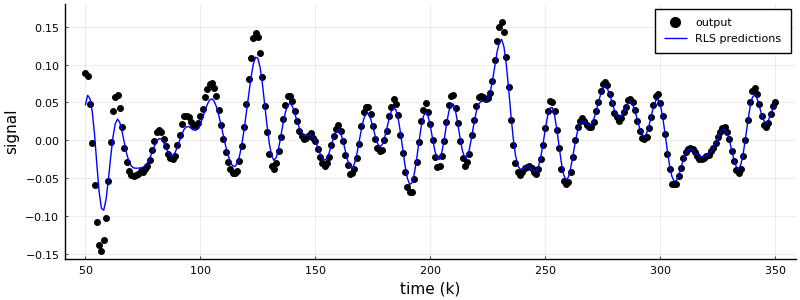

In [34]:
if (ts-tt) > 300
    scatter(tt:tt+300, output[tt:tt+300], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:tt+300, predictions_RLS[tt:tt+300], color="blue", label="RLS predictions")
else
    scatter(tt:ts, output[tt:ts], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:ts, predictions_RLS[tt:ts], color="blue", label="RLS predictions")
end

In [35]:
# Prepare array
simulations_RLS = zeros(T,)
simulations_RLS[1:ts] = output[1:ts]

# Simulation
for k in ts:T
    
    # Update data vector
    ϕx = ϕ([simulations_RLS[k-1:-1:k-M1_m]; input[k:-1:k-M2_m]; zeros(M3_m,)])
    
    # Prediction
    simulations_RLS[k] = w_k'*ϕx
    
end

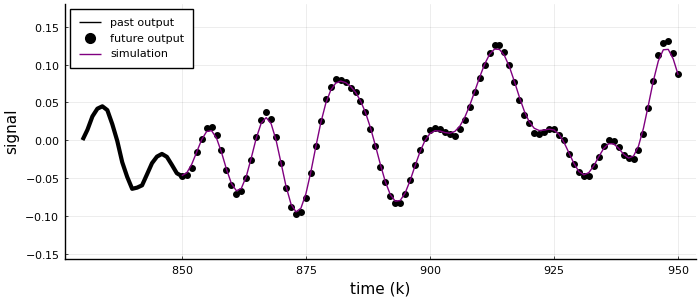

In [36]:
past = 20
ylims=[minimum(output[tt:T]), maximum(output[tt:T])]
plot(ts-past:ts, output[ts-past:ts], color="black", linewidth=3, label="past output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(700,300))

if T-ts > 100
    scatter!(ts:ts+100, output[ts:ts+100], color="black", label="future output", xlabel="time (k)", ylabel="signal")
    plot!(ts:ts+100, simulations_RLS[ts:ts+100], color="purple", label="simulation")
else
    scatter!(ts:T, output[ts:T], color="black", label="future output", xlabel="time (k)", ylabel="signal")
    plot!(ts:T, simulations_RLS[ts:T], color="purple", label="simulation")
end

In [37]:
savefig("figures/NARMAX-simulation_deg"*string(deg_m)*"_order"*string(M_m)*"_RLS.png")

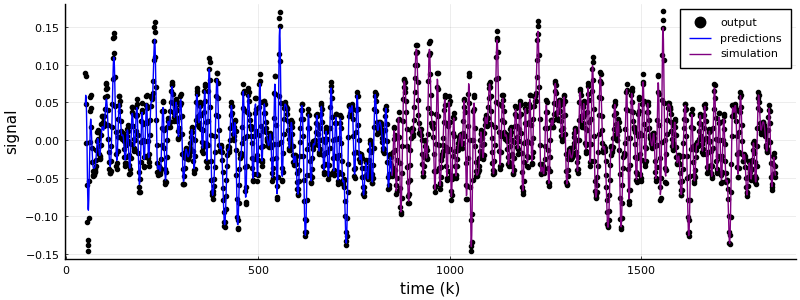

In [38]:
# Full signal
ylims=[minimum(output[tt:T]), maximum(output[tt:T])]
scatter(tt:T, output[tt:T], color="black", markersize=3, label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
plot!(tt:ts, predictions_RLS[tt:ts], color="blue", label="predictions")
plot!(ts:T, simulations_RLS[ts:T], color="purple", label="simulation")

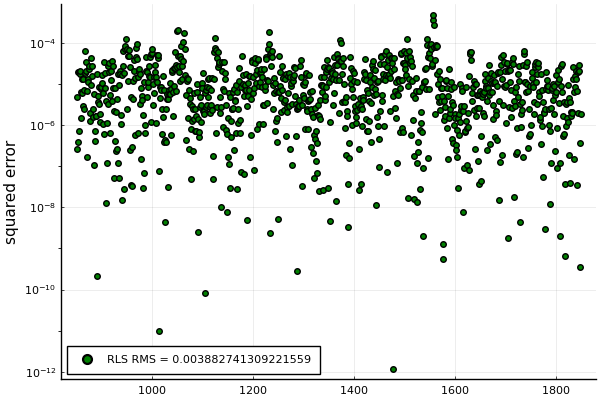

In [39]:
sqerror_RLS = (simulations_RLS[ts:T] - output[ts:T]).^2
RMS_RLS = sqrt(mean(sqerror_RLS))

scatter(ts:T, sqerror_RLS, label="RLS RMS = "*string(RMS_RLS), color="green", ylabel="squared error", yscale=:log10)

## Comparison

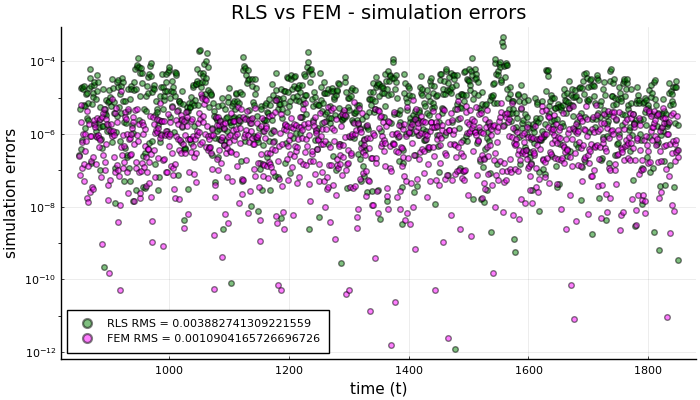

In [40]:
# Comparing simulation errors between PEM and FEM
scatter(ts:T, 
        sqerror_RLS, 
        color="green", 
        alpha=0.5,
        markersize=4, 
        size=(700,400), 
        yscale=:log10,
        xlabel="time (t)", 
        ylabel="simulation errors",
        label="RLS RMS = "*string(RMS_RLS))
scatter!(ts:T, 
         sqerror_FEM, 
         color="magenta", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(RMS_FEM),
         title="RLS vs FEM - simulation errors")

In [41]:
savefig("figures/NARMAX-errors_deg"*string(deg_m)*"_order"*string(M_m)*".png")

In [42]:
prop_beaten = mean(sqerror_FEM .< sqerror_RLS)
println("Proportion FEM < RLS = "*string(round(prop_beaten*100))*"%")

Proportion FEM < RLS = 83.0%
